<a href="https://colab.research.google.com/github/Lutris98/PersonalProject/blob/main/2.Visualization/Quant_Machine1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install mplfinance

In [ ]:
from pandas_datareader import data as pdr #datareader가 필요함
import yfinance as yf #해외주식 한정 정확
import datetime
yf.pdr_override()
df=pdr.get_data_yahoo('DADA')
df=df[['Open','High','Low','Close','Volume']]
df=df.iloc[-91:-1] #실제 판단은 한 분기단위로 
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-10-08,27.350000,27.690001,26.530001,27.129999,764900
2020-10-09,27.469999,31.150000,27.309999,29.690001,4003800
2020-10-12,30.820000,34.330002,30.820000,33.400002,2665200
2020-10-13,33.000000,34.500000,31.010000,34.049999,2364500
2020-10-14,34.349998,36.139999,31.820000,32.750000,2580500
...,...,...,...,...,...
2021-02-10,44.939999,45.497002,42.615002,44.560001,1673300
2021-02-11,44.860001,46.950001,44.419998,44.930000,1350100
2021-02-12,44.650002,45.270000,44.070000,44.560001,422700


#1.캔들차트

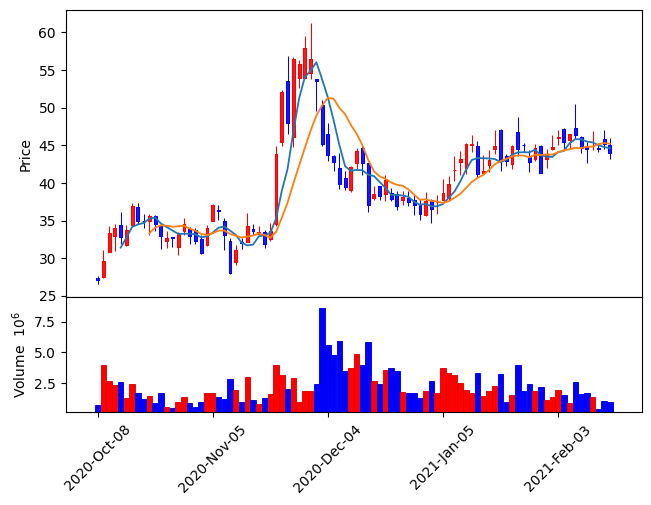

In [ ]:
import mplfinance as mpf
import matplotlib.pyplot as plt
kwargs={'type':'candle','mav':(5,10),'volume':True} #캔들차트는 제목 따로 달아야함
mc=mpf.make_marketcolors(up='r',down='b',inherit=True)
s=mpf.make_mpf_style(marketcolors=mc)
mpf.plot(df,**kwargs,style=s)

#2.볼린저밴드

In [ ]:
df['MA20']=df['Close'].rolling(window=20,min_periods=1).mean() #볼린저밴드자체는 MA20으로 만든다
std=df['Close'].rolling(window=20,min_periods=1).std() #둘다 close rolling해서 만든다
std.fillna(method='bfill',inplace=True) #std만 초깃값이 빈다
df['Upper']=df['MA20']+2*std
df['Lower']=df['MA20']-2*std
df['%B']=100*(df.Close-df.Lower)/(df.Upper-df.Lower)
df['TP']=(df['High']+df['Lower']+df['Close'])/3 #MFI만 필요한 수치
df['PMF']=0
df['NMF']=0
df

,Open,High,Low,Close,Volume,MA20,Upper,Lower,%B,TP,PMF,NMF
Date,,,,,,,,,,,,
2020-10-08,27.350000,27.690001,26.530001,27.129999,764900,27.129999,30.750388,23.509610,50.000000,26.109870,0,0
2020-10-09,27.469999,31.150000,27.309999,29.690001,4003800,28.410000,32.030389,24.789611,67.677670,28.543204,0,0
2020-10-12,30.820000,34.330002,30.820000,33.400002,2665200,30.073334,36.378392,23.768275,76.380943,30.499426,0,0
2020-10-13,33.000000,34.500000,31.010000,34.049999,2364500,31.067500,37.572604,24.562396,72.924300,31.037465,0,0
2020-10-14,34.349998,36.139999,31.820000,32.750000,2580500,31.404000,37.235117,25.572883,61.541527,31.487627,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-10,44.939999,45.497002,42.615002,44.560001,1673300,44.102000,47.270187,40.933812,57.228131,43.663605,0,0
2021-02-11,44.860001,46.950001,44.419998,44.930000,1350100,44.287500,47.166431,41.408568,61.158662,44.429523,0,0
2021-02-12,44.650002,45.270000,44.070000,44.560001,422700,44.433500,47.029361,41.837639,52.436599,43.889214,0,0


In [ ]:
for i in range(len(df)-1): #0부터 개수-2까지
  if df.TP.values[i]<df.TP.values[i+1]: 
    df.PMF.values[i+1]=df.TP.values[i+1]*df.Volume.values[i+1] #그냥 값자체에 가중치곱하면 흐름으로 처리
    df.NMF.values[i+1]=0
  elif df.TP.values[i]>df.TP.values[i+1]:
    df.NMF.values[i+1]=df.TP.values[i+1]*df.Volume.values[i+1] #그냥 값자체에 가중치곱하면 흐름으로 처리
    df.PMF.values[i+1]=0
MF=df.PMF.rolling(window=10).sum()/df.NMF.rolling(window=10).sum() #유일하게 10으로 rolling
df['MFI']=100-100/(1+MF)

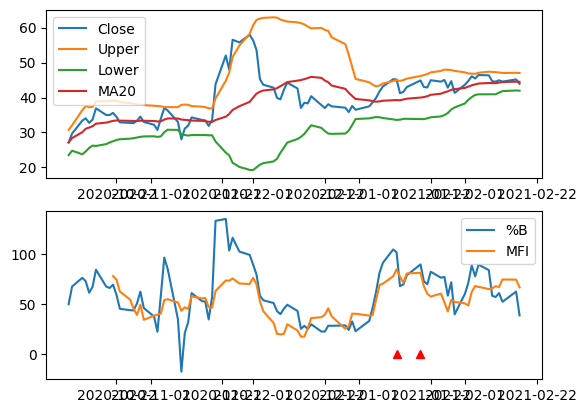

In [ ]:
plt.subplot(2,1,1)
plt.plot(df.index,df.Close,label='Close')
plt.plot(df.index,df.Upper,label='Upper')
plt.plot(df.index,df.Lower,label='Lower')
plt.plot(df.index,df.MA20,label='MA20')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(df.index,df['%B'],label='%B')
plt.plot(df.index,df.MFI,label='MFI')
buy=[]
sell=[]
df.index=df.index.date #날짜만!
for i in range(len(df)):
  if df['%B'].values[i]>80 and df.MFI.values[i]>80:
    plt.plot(df.index.values[i],0,'r^')
    buy.append(df.index.values[i])
  if df['%B'].values[i]<20 and df.MFI.values[i]<20:
    plt.plot(df.index.values[i],0,'bv')
    sell.append(df.index.values[i])
plt.legend(loc='best')

<BarContainer object of 90 artists>

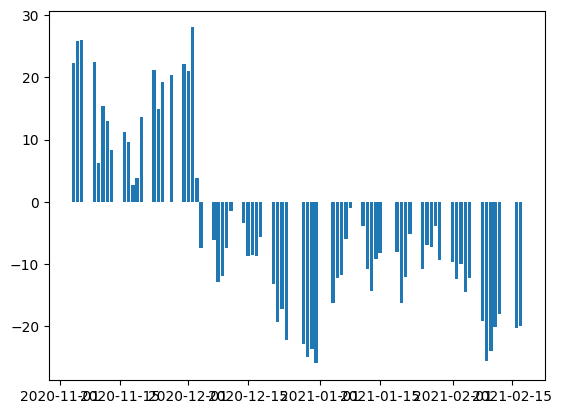

In [ ]:
intensity=df.Volume*(2*df.Close-df.High-df.Low)/(df.High-df.Low) #거래량을 곱해준다음 rolling해서 나눠주기
df['%I']=100*intensity.rolling(window=20).sum()/df.Volume.rolling(window=20).sum()
plt.bar(df.index,df['%I'],label='%I in 20days')

#3.삼중창
EMA130&스토캐스틱 (첫번째 창 버리기)

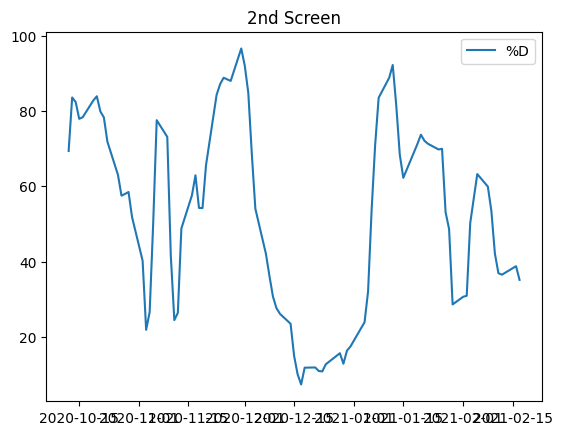

In [ ]:
L14=df.Low.rolling(window=14,min_periods=1).min() 
H14=df.High.rolling(window=14,min_periods=1).max()
df['%K']=100*(df['Close']-L14)/(H14-L14)
df['%D']=df['%K'].rolling(window=3).mean() 
plt.plot(df.index,df['%D'],label='%D')
plt.title('2nd Screen')
plt.legend(loc='best')

Text(0.5, 1.0, '3rd Screen')

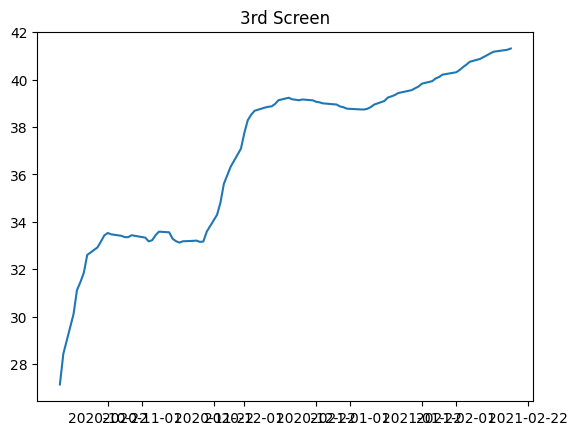

In [ ]:
df['EMA130']=df['Close'].ewm(span=130).mean()
plt.plot(df.index,df['EMA130'],label='EMA130')
for i in range(len(df)-1):
  if df.EMA130.values[i]<df.EMA130.values[i+1] and df['%D'].values[i]<=20 and df['%D'].values[i+1]>20:
    plt.plot(df.index[i+1],df.EMA130.mean(),'r^') #평균으로 해야 마커가 일관성 있게 보임
    buy.append(df.index.values[i])
  elif df.EMA130.values[i]>=df.EMA130.values[i+1] and df['%D'].values[i]>=80 and df['%D'].values[i+1]<80: 
    plt.plot(df.index[i+1],df.EMA130.mean(),'bv')
    sell.append(df.index.values[i])
plt.title('3rd Screen')

#종합

In [ ]:
print('매수시점:',buy)
print('매도시점:',sell)

매수시점: [datetime.date(2021, 1, 12), datetime.date(2021, 1, 19)]
매도시점: []
